In [1]:
import torch
import torchvision
import cv2
from pycocotools import mask


In [2]:
import os
import numpy as np
import json
import random 
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
import detectron2


In [3]:
def get_resize_ratio(file_path):
    #read image to resize
    image = cv2.imread(file_path)
    #resize to 1000*1000
    resized_image = cv2.resize(image, (480, 480))  
    #get resize ratio      
    resize_ratio = resized_image.shape[0] / image.shape[0]
    #write to file
    cv2.imwrite(file_path, resized_image)
    return resize_ratio

In [4]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for i, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.png')]):
        mask_file = os.path.join(directory, filename)

        #要處理每場圖片的大小 要resize
        resize_ratio = get_resize_ratio(mask_file)

        with open(mask_file.replace(".png", ".json")) as f:
            img_anns = json.load(f)
        # 載入圖像
        image = cv2.imread(mask_file)

        lower_black = np.array([0,0,0])
        upper_black = np.array([0,0,0])

        # 檢測圖像中黑色位置
        black_mask = cv2.inRange(image, lower_black, upper_black)

        # 將黑色位置設置為零，以達到檢測除了黑色以外的所有位置的目的
        mask = cv2.bitwise_not(black_mask)


        # 尋找輪廓
        contours, hierarchy  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                
        record = {}
        filename = os.path.join(directory, img_anns["imagePath"])
        record["file_name"] = filename
        record["height"] = 480
        record["width"] = 480
        record["image_id"] = i
        annos = img_anns["shapes"]
        

        for contour in contours:
            # 繪製輪廓
            cv2.drawContours(image, contour, -1, (0,255,0), 3)

        objs = []
        for contour in contours:
            # 遍歷輪廓中的所有點
            px = []
            py = []
            points = []
            for point in contour:
                # 印出座標
                px.append((point[0][0]))
                py.append((point[0][1]))
                points.append((point[0][0], point[0][1]))
                poly = [point for x in points for point in x]
                #segmentation_mask = np.asarray(poly, dtype=np.uint8)
                #rle = segmentation_mask.encode()
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(annos[0]['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
classes = ['powder_uncover', 'powder_uneven', 'scratch']

data_path = '/Users/david/Desktop/DIP_final/segmentation/data/'


for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

In [6]:
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer


In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = 'cpu'
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.OUTPUT_DIR = "/Users/david/Desktop/DIP_final/segmentation/outputModels"

In [8]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[01/09 19:36:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

In [ ]:
#trainer.train()

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("category_test", )
predictor = DefaultPredictor(cfg)

In [33]:

test_dataset_dicts = get_data_dicts(data_path+'test', classes)


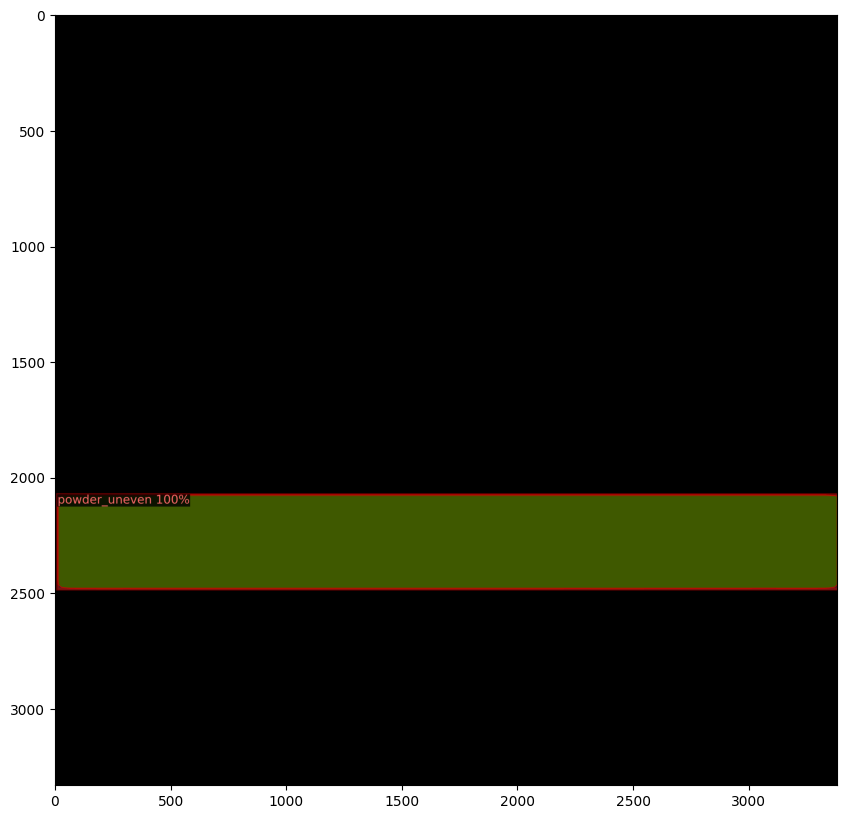

In [12]:
# 讀取圖像
image = cv2.imread("/Users/david/Desktop/DIP_final/segmentation/data/train_mask/converted__ 0174.png")
outputs = predictor(image)
v = Visualizer(image[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #v = v.get_output()
image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

    #cv2.imwrite(out_path, image)
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

# save instance image

In [11]:
'''
for d in test_dataset_dicts:    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #v = v.get_output()
    image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    #image[image != 0] = 255
    filename = d["file_name"]
    start_index = filename.find("test/")
    substring = filename[start_index+5:]
    out_path = os.path.join(data_path+'out', substring)
    #cv2.imwrite(out_path, image)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
'''

'\nfor d in test_dataset_dicts:    \n    img = cv2.imread(d["file_name"])\n    outputs = predictor(img)\n    v = Visualizer(img[:, :, ::-1],\n                   metadata=microcontroller_metadata, \n                   scale=1, \n                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels\n    )\n    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))\n    #v = v.get_output()\n    image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)\n    #image[image != 0] = 255\n    filename = d["file_name"]\n    start_index = filename.find("test/")\n    substring = filename[start_index+5:]\n    out_path = os.path.join(data_path+\'out\', substring)\n    #cv2.imwrite(out_path, image)\n    plt.figure(figsize = (14, 10))\n    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))\n'

# save to grayscale

In [12]:
from detectron2.utils.visualizer import ColorMode
for d in test_dataset_dicts:    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img) 
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    mask_array = outputs['instances'].to("cpu").pred_masks.numpy()
    num_instances = mask_array.shape[0]     
    mask_array = np.moveaxis(mask_array, 0, -1)  
    mask_array_instance = []
    output = np.zeros_like(img)      
    num,h,width = mask_array.shape

    for i in range(num_instances):
        mask_array_instance.append(mask_array[:, :, i:(i+1)])
        output = np.where(mask_array_instance[i] == True, 255, output)

    filename = d["file_name"]
    start_index = filename.find("test/")
    substring = filename[start_index+5:]
    out_path = os.path.join(data_path+'out_binary', substring)
    #cv2.imwrite(out_path, output)
   

/Users/david/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 

# dice score

In [13]:
from keras import backend as K
def dice_coef(y_true, y_pred):
    y_true[y_true > 0] = 1
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    dice_score = 2 * intersection / union
    return dice_score.numpy()


# iou

In [31]:
def euclid(v1, v2):
    distance = 0
    for i in range(len(v1)):
        distance += (v1[i] - v2[i])**2
    return distance / len(v1)

In [32]:
def calculate_similarity_gt(box1, box2):#ps比out_iou長 存回ps 若相反則import時倒轉
    new_box = []
    for index2, box2_item in enumerate(box2):
        similarity = []
        for index1, box1_item in enumerate(box1):
            similarity.append(euclid(box2_item, box1_item))
        new_box.append(box1[similarity.index(min(similarity))])
    new_box = [tuple(b) for b in new_box]
    return list(set(new_box))

'''
if(len(ps) > len(list_of_lists)):
    ps = calculate_similarity_gt(ps, list_of_lists)
else:
    list_of_lists = calculate_similarity_gt(list_of_lists, ps)


#print(ps)
print(list_of_lists)
'''

'\nif(len(ps) > len(list_of_lists)):\n    ps = calculate_similarity_gt(ps, list_of_lists)\nelse:\n    list_of_lists = calculate_similarity_gt(list_of_lists, ps)\n\n\n#print(ps)\nprint(list_of_lists)\n'

In [33]:
def calculate_iou(box1, box2):
    # Calculate area of each bounding box
    x1, y1, x2, y2 = box1
    box1_area = abs((x2 - x1) * (y2 - y1))
    x1, y1, x2, y2 = box2
    box2_area = abs((x2 - x1) * (y2 - y1))
    # Calculate intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    #if x1 < x2 and y1 < y2:
    intersection_area = abs((x2 - x1) * (y2 - y1))
    #else:
    #intersection_area = np.abs(intersection_area)
    #print(intersection_area)
    # Calculate union area
    
    union_area = box1_area + box2_area - intersection_area
    #print(f"box1{box1_area}")
    #print(f"box2{box2_area}")
    #print(f"union{union_area}")
    #print(f"intertection{intersection_area}")
    if(union_area < 0):return 0

    # Return IOU
    return intersection_area / union_area



#for i, b1 in enumerate(out_iou):
#    b2 = ps[i]
#    iou = calculate_iou(b1, b2)
#    print(f'IOU for boxes {i}: {iou}')



In [34]:
def IOU_file(filename):
        json_file = filename
        img = cv2.imread(json_file[:-5] + '.png')
        outputs = predictor(img)#predicted outputs
        with open(json_file, "r") as f:#get real json's coordinate
            data = json.load(f)
            annos = data["shapes"]
            ps = []
            for anno in annos:
                    px = [a[0] for a in anno['points']] # x coord
                    py = [a[1] for a in anno['points']] # y-coord
                    poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
                    poly = [p for x in poly for p in x]
                    ps.append(poly)
        #print(ps)
        ps = sorted(ps, key=lambda x: x[0])#get real json's coordinate
        out_iou = outputs["instances"].pred_boxes.tensor.cpu()#sort cuz it's in wrong order
        #print(out_iou)
        list_of_lists = [t.tolist() for t in out_iou]
        list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
        
        
        
        iou = 0
        if(len(ps) < len(list_of_lists)):
            list_of_lists = calculate_similarity_gt(list_of_lists, ps)
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(list_of_lists):
                b2 = ps[i]
                iou += calculate_iou(b1, b2)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(list_of_lists)
        elif(len(ps) > len(list_of_lists)):
            ps = calculate_similarity_gt(ps, list_of_lists)
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(ps):
                b2 = list_of_lists[i]
                iou += calculate_iou(b1, b2)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(ps)
        else:
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(ps):
                b2 = list_of_lists[i]
                iou += calculate_iou(b2, b1)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(ps)

        if(iou > 1): iou = 1#有些bug>1我抓不到
            
        return iou
        #print(list_of_lists)
        #print(ps)

# GUI

In [30]:

import PySimpleGUI as sg
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
from PIL import Image, ImageTk
import io
import os
import os.path
import time


file_types = [("JPEG (*.jpg)", "*.jpg"),
              ("All files (*.*)", "*.*")]

#config_file = r"None"
#ckpt_file = r"Please read your check point file"
#img_file = r"Please read your img path"
#image_files = r"Please read your img path"

# 建立 detectron2 的 predictor
#cfg = model_zoo.get_config('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
#cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
#cfg.MODEL.WEIGHTS = "/Users/david/Desktop/DIP_final/outputModels1/model_final.pth"
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

#predictor = DefaultPredictor(cfg)

file_types = [("JPEG (*.jpg)", "*.jpg"),
              ("All files (*.*)", "*.*")]
file_list_column = [
    [
        sg.Listbox(
            values=[], enable_events=True, size=(40, 30), key="-FILE LIST-"
        )
    ],
]
height, width = 360, 360
def main():
    
    layout = [
        #sg.VSeperator(),
		#[sg.Text('config file',size=(16,1)), sg.In(config_file,size=(80,1), key='config'), sg.FileBrowse(file_types=file_types)],
        #[sg.Text('model checkpoint',size=(16,1), auto_size_text=False), sg.In(ckpt_file,size=(80,1), key='ckpt'), sg.FileBrowse(file_types=file_types)],
		#[sg.Text('Path to image',size=(16,1)), sg.In(img_file,size=(80,1), key='image'), sg.FileBrowse(file_types=file_types),sg.Button("Load Image"),],
        
        [
        sg.Text("Image Folder"),
        sg.In(size=(80, 1), enable_events=True, key="-FOLDER-"),
        sg.FolderBrowse('瀏覽'),
        ],
		[sg.Text('Device',size=(10,1)), sg.Combo(['cuda:0','cpu'],default_value='cpu',key='device')],
        [sg.Text(size=(40, 1), key="-TOUT-")],
		[sg.Text("File list",size=(10,1)),sg.Text("Source Image",size=(50,1)),sg.Text("Segmented Image",size=(65,1))],
        [sg.Column(file_list_column), sg.Image(key="source_image",size=(height,width),background_color='white'),
        sg.Image(key="segmented_image",size=(height,width),background_color='white')],
        [sg.Button('Segment'), sg.Exit()],
        #[sg.Text('IOU',size=(4,1)),  sg.In(size=(100,1), key='iou')],
        #[sg.Text('AP50',size=(4,1)),  sg.In(size=(100,1), key='ap')],
        [sg.Text('Dice',size=(4,1)),  sg.In(size=(100,1), key='dice')],
        [sg.Text('FPS',size=(4,1)),  sg.In(size=(100,1), key='fps')]
        ]
    window = sg.Window('detectron2', 
                   layout,
                   default_element_size=(14,2),
                   text_justification='right',
                   auto_size_text=False
                   # element_justification='c'
                   )

    while True:
        event, values = window.read()

        if event == "Exit" or event == sg.WIN_CLOSED:
            break

        if event == "-FOLDER-":
            folder = values["-FOLDER-"]
            try:
                file_list = os.listdir(folder)
            except:
                file_list = []

            fnames = [
                f
                for f in file_list
                if os.path.isfile(os.path.join(folder, f))
                and f.lower().endswith((".png", ".gif"))
            ]
            window["-FILE LIST-"].update(fnames)
        elif event == "-FILE LIST-":  
            try:
                filename = os.path.join(
                    values["-FOLDER-"], values["-FILE LIST-"][0]
                )
                print(filename)
                image = Image.open(filename)
                image.thumbnail((400, 400))
                bio = io.BytesIO()
                # Actually store the image in memory in binary 
                image.save(bio, format="PNG")
                # Use that image data in order to 
                window["source_image"].update(data=bio.getvalue())
            except:
                pass


        if event == "Load Image":
            start_time = time.time()  # 記錄目前的時間
            filename = values["image"]
            image_name = os.path.basename(filename)
            if os.path.exists(filename):
                image = Image.open(values["image"])
                image.thumbnail((400, 400))
                bio = io.BytesIO()
                # Actually store the image in memory in binary 
                image.save(bio, format="PNG")
                # Use that image data in order to 
                window["source_image"].update(data=bio.getvalue())

        if event == "image":
            file_path = values["image"]
            img = cv2.imread(file_path)
            # 將圖片轉換成 PySimpleGUI 可以顯示的格式
            img_bytes = cv2.imencode(".png", img)[1].tobytes()
            # 將圖片顯示在 PySimpleGUI 的視窗中
            window["source_image"].update(data=img_bytes)

            
        if event == "Segment":
            start_time = time.time()  # 記錄目前的時間
            filename = os.path.join(
                    values["-FOLDER-"], values["-FILE LIST-"][0]
                )
            # 使用 detectron2 偵測物件
            #filename = values["image"]
            label_path = filename.replace("image", "label")
            mask_path = filename.replace("image", "mask")
            cfg = model_zoo.get_config('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')
            cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
            cfg.MODEL.WEIGHTS = "/Users/david/Desktop/DIP_final/segmentation/outputModels/model_final.pth"
            cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
            # 使用 detectron2 偵測圖片中的物體
            img = cv2.imread(mask_path)
            img = cv2.resize(img,(400,400))
            #iou_num = IOU_file(label_path[:-3] + 'json')
            print(label_path[:-3] + 'json')
            outputs = predictor(img)
            v = Visualizer(img[:, :, ::-1],
                        metadata=microcontroller_metadata, 
                        scale=1, 
                        instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
            )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            mask_array = outputs['instances'].to("cpu").pred_masks.numpy()
            num_instances = mask_array.shape[0]     
            mask_array = np.moveaxis(mask_array, 0, -1)  
            mask_array_instance = []
            output = np.zeros_like(img)   

            for i in range(num_instances):
                mask_array_instance.append(mask_array[:, :, i:(i+1)])
                output = np.where(mask_array_instance[i] == True, 255, output)
            # 將圖片轉換成 PySimpleGUI 可以顯示的格式
            #print(output)
            img = img.astype(np.float32)
            output = output.astype(np.float32)
            #print(dice_coef(img, output))
            img_bytes = cv2.imencode(".png", output)[1].tobytes()
            # 將圖片顯示在 PySimpleGUI 的視窗中
            #window["iou"].update(iou_num)
            elapsed_time = time.time() - start_time  # 計算執行時間
            window["dice"].update(dice_coef(img, output))
            window["fps"].update(elapsed_time)
            window["segmented_image"].update(data=img_bytes)
            

            
    window.close()


if __name__ == "__main__":

    main()


2023-01-09 12:50:13.229 python[28698:4632506] +[CATransaction synchronize] called within transaction
2023-01-09 12:50:13.281 python[28698:4632506] +[CATransaction synchronize] called within transaction


IndexError: list index out of range

In [ ]:
'''
import cv2
import numpy as np
# 載入圖像
image = cv2.imread("/Users/david/Desktop/class_data/Train/powder_uncover/mask/converted_ 0129.png")

# 定義紅色顏色範圍
lower_red = np.array([0,0,100])
upper_red = np.array([100,100,255])

# 檢測圖像中的紅色
mask = cv2.inRange(image, lower_red, upper_red)

# 尋找輪廓
contours, hierarchy  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 遍歷所有輪廓
for contour in contours:
    # 繪製輪廓
    cv2.drawContours(image, contour, -1, (0,255,0), 3)
objs = []
points =[]
px = []
py = []
for contour in contours:
    # 遍歷輪廓中的所有點
    for point in contour:
        # 印出座標
        px.append((point[0][0]))
        py.append((point)[0][1])
        points.append((point[0][0], point[0][1]))
        poly = [point for x in points for point in x]
    
obj = {
    "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
    #"bbox_mode": BoxMode.XYXY_ABS,
    "segmentation": [poly],
    "iscrowd": 0
}
        
objs.append(obj)
'''

In [ ]:
'''
import json
import numpy as np
with open("/Users/david/Desktop/DIP_final/segmentation/data/test/Converted_ 3153.json") as f:
    img_anns = json.load(f)
    record = {}
    annos = img_anns["shapes"]
    objs = []
    print(annos)
    for anno in annos:
        px = [a[0] for a in anno['points']] # x coord
        #print(px)
        py = [a[1] for a in anno['points']] # y-coord
        poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
        poly = [p for x in poly for p in x]
        obj = {

            "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
            "bbox_mode": BoxMode.XYXY_ABS,
            #"segmentation": [poly],
            "category_id": classes.index(anno['label']),
            "iscrowd": 0
        }
        objs.append(obj)
    record["annotations"] = objs
'''

In [ ]:
"""
import json
import numpy as np
with open("/Users/david/Desktop/malignant_238.json") as f:
    img_anns = json.load(f)
    record = {}
    annos = img_anns["shapes"]
    objs = []
    for anno in annos:
        print(1)
        px = [a[0] for a in anno['points']] # x coord
      
        py = [a[1] for a in anno['points']] # y-coord
        #print(py)
        poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
        poly = [p for x in poly for p in x]
        #print(poly)
        obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "iscrowd": 0
            }
        objs.append(obj)
    record["annotations"] = objs
"""

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
from keras import backend as K

In [57]:
from keras import backend as K
def dice_coef(y_true, y_pred):
    y_true[y_true > 0] = 1
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    dice_score = 2 * intersection / union
    return dice_score.numpy()


In [58]:
import numpy as np
from keras import backend as K

B = cv2.imread('/Users/david/Desktop/DIP_final/segmentation/data/out_binary/converted_ 0413.png')
A = cv2.imread('/Users/david/Desktop/DIP_final/segmentation/data/test/converted_ 0413.png')
# 将 A 和 B 转换为 float32 类型，方便计算
A = A.astype(np.float32)
B = B.astype(np.float32)
dice_coef(A, B)


0.9691987

In [ ]:
import matplotlib.pyplot as plt
import os
dir1 = '/Users/david/Desktop/DIP_final/segmentation/data/out/'
dir2 = '/Users/david/Desktop/DIP_final/segmentation/data/test/'
image1 = cv2.imread('/Users/david/Desktop/DIP_final/segmentation/data/out/converted_ 0425.png')
image2 = cv2.imread('/Users/david/Desktop/DIP_final/segmentation/data/test/converted_ 0425.png')

# display the image using matplotlib
#plt.imshow(image)
#plt.show()

#for filename in [file for file in os.listdir(dir2) if file.endswith('.png')]:
y_pred = cv2.imread(image1)/255.
y_true = cv2.imread(image2)/255.
#    y_pred = y_pred.reshape((-1, 480, 480, 3 ))
#    y_true = y_true.reshape((-1, 480, 480, 3 ))
#    dice_score = dice(dir2+filename, dir1+filename)
#    print ("Dice Coeff: {}".format(dice_score))
X= K.flatten(y_true)
Y = K.flatten(y_pred)
intersection = K.sum(X * Y)


In [ ]:
y_pred = cv2.imread(dir1+filename)/255.
y_true = cv2.imread(dir2+filename)/255.
y_pred = y_pred.reshape((-1, 480, 480, 3 ))
y_true = y_true.reshape((-1, 480, 480, 3 ))
dice_score = dice_coefficient(dir2+filename, dir1+filename)
print ("Dice Coeff: {}".format(dice_score))

In [ ]:
same_area = [0]
for i in range(image1.shape[0]):
    for j in range(image1.shape[1]):
        if image1[i, j].all() == image2[i, j].all():
            same_area[0] += 1
print(same_area[0]/(480 * 480))

In [ ]:
it = iter(image)
for row in image:
    for pixel in row:
        if (pixel > 0).any():
            print(pixel)

In [ ]:
y_pred = cv2.imread('/Users/david/Desktop/DIP_final/segmentation/data/out/Converted_ 0003.png')/255.
y_true = cv2.imread('/Users/david/Desktop/DIP_final/segmentation/data/test/Converted_ 0003.png')/255.

print(y_pred.shape)
print(y_true.shape)

y_pred = y_pred.reshape((-1, 480, 480, 3 ))
y_true = y_true.reshape((-1, 480, 480, 3 ))

#print(y_pred.shape)
#print(y_true.shape)

In [ ]:
dice_score = dice_coefficient(y_true, y_pred)

print ("Dice Coeff: {}".format(dice_score))

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.png')]:
        mask_file = os.path.join(directory, filename)

        #要處理每場圖片的大小 要resize
        resize_ratio = get_resize_ratio(mask_file)

        with open(mask_file.replace(".png", ".json")) as f:
            img_anns = json.load(f)
        # 載入圖像
        image = cv2.imread(mask_file)

        # 定義紅色顏色範圍
        lower_black = np.array([0,0,0])
        upper_black = np.array([0,0,0])

        # 檢測圖像中黑色位置
        black_mask = cv2.inRange(image, lower_black, upper_black)

        # 將黑色位置設置為零，以達到檢測除了黑色以外的所有位置的目的
        mask = cv2.bitwise_not(black_mask)

        # 尋找輪廓
        contours, hierarchy  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                
        record = {}
        filename = os.path.join(directory, img_anns["imagePath"])
        record["file_name"] = filename
        record["height"] = 480
        record["width"] = 480
      
        annos = img_anns["shapes"]
        objs = []

        for contour in contours:
            # 繪製輪廓
            cv2.drawContours(image, contour, -1, (0,255,0), 3)

        
        for contour in contours:
            # 遍歷輪廓中的所有點
            px = []
            py = []
            points = []
            for point in contour:
                # 印出座標
                px.append((point[0][0]*resize_ratio))
                py.append((point[0][1]*resize_ratio))
                points.append((point[0][0]*resize_ratio, point[0][1]*resize_ratio))
                poly = [point for x in points for point in x]
        
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(annos[0]['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
get_data_dicts('/Users/david/Desktop/DIP_final/segmentation/data/a', classes)

In [ ]:
import json
import numpy as np
with open("/Users/david/Desktop/malignant_238.json") as f:
    dataset_dicts = []
    img_anns = json.load(f)
    record = {}
    annos = img_anns["shapes"]
    objs = []
    for anno in annos:
        print(1)
        px = [a[0] for a in anno['points']] # x coord
      
        py = [a[1] for a in anno['points']] # y-coord
        #print(py)
        poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
        poly = [p for x in poly for p in x]
        #print(poly)
        obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "iscrowd": 0
            }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)




In [ ]:
dataset_dicts

In [ ]:

image = cv2.imread('/Users/david/Desktop/DIP_final/segmentation/data/test/converted__ 0003.png')

        # 定義紅色顏色範圍
lower_black = np.array([0,0,0])
upper_black = np.array([0,0,0])

# 檢測圖像中黑色位置
black_mask = cv2.inRange(image, lower_black, upper_black)

# 將黑色位置設置為零，以達到檢測除了黑色以外的所有位置的目的
mask = cv2.bitwise_not(black_mask)

        # 尋找輪廓
contours, hierarchy  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


for contour in contours:
            # 繪製輪廓
    cv2.drawContours(image, contour, -1, (0,255,0), 3)

plt.imshow(image)
plt.show()

for contour in contours:
        px = []
        py = []
        maxa =[]
        maxy =[]
        points = []
        for point in contour:
                px.append((point[0][0]*3))
                py.append((point[0][1]*3))
                points.append((point[0][0]*3, point[0][1]*3))
                poly = [point for x in points for point in x]
        print("another one")   
        print(f"minx:x{min(px)}")  
        print(f"minx:y{min(py)}")      
        maxa.append(max(px))
        maxy.append(max(py))   
        print(f"fuck{px}")
        print(f"py{py}")
        print(f"maxx{maxa}")
        print(f"maxy{maxy}")

In [ ]:

import PySimpleGUI as sg
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
from PIL import Image, ImageTk
import io
import os
import os.path


file_types = [("JPEG (*.jpg)", "*.jpg"),
              ("All files (*.*)", "*.*")]

#config_file = r"None"
#ckpt_file = r"Please read your check point file"
img_file = r"Please read your img path"
image_files = r"Please read your img path"

# 建立 detectron2 的 predictor
#cfg = model_zoo.get_config('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
#cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
#cfg.MODEL.WEIGHTS = "/Users/david/Desktop/DIP_final/outputModels1/model_final.pth"
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

#predictor = DefaultPredictor(cfg)

file_types = [("JPEG (*.jpg)", "*.jpg"),
              ("All files (*.*)", "*.*")]

height, width = 360, 360
def main():
    
    layout = [
        #sg.VSeperator(),
		#[sg.Text('config file',size=(16,1)), sg.In(config_file,size=(80,1), key='config'), sg.FileBrowse(file_types=file_types)],
        #[sg.Text('model checkpoint',size=(16,1), auto_size_text=False), sg.In(ckpt_file,size=(80,1), key='ckpt'), sg.FileBrowse(file_types=file_types)],
		[sg.Text('Path to image',size=(16,1)), sg.In(img_file,size=(80,1), key='image'), sg.FileBrowse(file_types=file_types),sg.Button("Load Image"),],
        
        
		[sg.Text('Device',size=(16,1)), sg.Combo(['cuda:0','cpu'],default_value='cpu',key='device')],
        [sg.Text(size=(40, 1), key="-TOUT-")],
		[sg.Text("Source Image",size=(16,1)),sg.Text("Segmented Image",size=(65,1))],
        [sg.Image(key="source_image",size=(height,width),background_color='white'),
        sg.Image(key="detected_image",size=(height,width),background_color='white'),
        sg.Image(key="segmented_image",size=(height,width),background_color='white')],
        [sg.Button('Segment'), sg.Exit()],
        #[sg.Text('IOU',size=(3,1)),  sg.In(size=(100,1), key='iou')],
        #[sg.Text('AP50',size=(3,1)),  sg.In(size=(100,1), key='ap')],
        [sg.Text('Dice',size=(3,1)),  sg.In(size=(100,1), key='dice')],
        [sg.Text('FPS',size=(3,1)),  sg.In(size=(100,1), key='fps')]
        ]
    window = sg.Window('detectron2', 
                   layout,
                   default_element_size=(14,2),
                   text_justification='right',
                   auto_size_text=False
                   # element_justification='c'
                   )

    while True:
        event, values = window.read()



        if event == "Exit" or event == sg.WIN_CLOSED:
            break
        if event == "Load Image":
            filename = values["image"]
            image_name = os.path.basename(filename)
            print(image_name)
            if os.path.exists(filename):
                image = Image.open(values["image"])
                image.thumbnail((400, 400))
                bio = io.BytesIO()
                # Actually store the image in memory in binary 
                image.save(bio, format="PNG")
                # Use that image data in order to 
                window["source_image"].update(data=bio.getvalue())

        if event == "image":
            file_path = values["image"]
            img = cv2.imread(file_path)
            # 將圖片轉換成 PySimpleGUI 可以顯示的格式
            img_bytes = cv2.imencode(".png", img)[1].tobytes()
            # 將圖片顯示在 PySimpleGUI 的視窗中
            window["source_image"].update(data=img_bytes)

        '''
        if event == "Segment":
            # 使用 detectron2 偵測物件
            filename = values["image"]
            label_path = filename.replace("image", "label")

            cfg = model_zoo.get_config('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
            cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
            cfg.MODEL.WEIGHTS = "/Users/david/Desktop/DIP_final/segmentation/data/out/model_final.pth"
            cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
            # 使用 detectron2 偵測圖片中的物體
            img = cv2.imread(filename)
            img = cv2.resize(img,(400,400))
            iou_num = IOU_file(label_path[:-3] + 'json')
            outputs = predictor(img)
            v = Visualizer(img[:, :, ::-1],
                        metadata=microcontroller_metadata, 
                        scale=1, 
                        instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
            )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            # 將圖片轉換成 PySimpleGUI 可以顯示的格式
    
            img_bytes = cv2.imencode(".png", v.get_image())[1].tobytes()
            # 將圖片顯示在 PySimpleGUI 的視窗中
            window["iou"].update(iou_num)
            window["ap"].update(ap50['bbox']['AP50'])
            window["detected_image"].update(data=img_bytes)
        '''
        if event == "Segment":
            # 使用 detectron2 偵測物件
            filename = values["image"]
            label_path = filename.replace("image", "label")
            print(label_path)
            mask_path = filename.replace("image", "mask")
            print(mask_path)
            if event == "Segment":
                cfg = model_zoo.get_config("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
                cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
                cfg.MODEL.WEIGHTS = "/Users/david/Desktop/DIP_final/segmentation/outputModels/model_final.pth"
                cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
            # 使用 detectron2 偵測圖片中的物體
                img = cv2.imread(mask_path)
                
                img = cv2.resize(img,(400,400))
                
                iou_num = IOU_file(label_path[:-3] + 'json')
                outputs = predictor(img)
                
                v = Visualizer(img[:, :, ::-1],
                            metadata=microcontroller_metadata, 
                            scale=1, 
                            instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
                )
                v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
                # 將圖片轉換成 PySimpleGUI 可以顯示的格式
    
                img_bytes = cv2.imencode(".png", v.get_image())[1].tobytes()
                # 將圖片顯示在 PySimpleGUI 的視窗中
                #window["iou"].update(iou_num)
                #window["ap"].update(ap50['bbox']['AP50'])
                window["segmented_image"].update(data=img_bytes)
        



            
    window.close()


if __name__ == "__main__":

    main()
